In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [32]:
def window_dataset(series, window_size:int, batch_size:int=32):
    """
    From a time series, create a set of learnable windows.
    
    Parameters
    ---------
    Series
        The series to learn
    Window size
        the size of window to learn from
    batch size
        The size of each batch in the dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # We want windows of the same length!
    # We also want batches of the window size
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    # Use the previous window_size-1 data points to predict the next one, and shuffle the windows.
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.shuffle(len(series))
    return dataset.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size:int):
    """
    Use a model to predict a small range into the future.
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    return model.predict(ds)


<IPython.core.display.Javascript object>

In [4]:
def trend(time: np.array, slope: float) -> np.array:
    return slope * time


def seasonal_pattern(season_time: np.array):
    """
    This is arbitrary -- there could be multiple seasonal patterns.
    """
    return np.where(
        season_time < 0.4, np.cos(season_time * 2 * np.pi), np.exp(-3 * season_time)
    )


def seasonality(time: np.array, period: float, amplitude: float = 1, phase: float = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time: np.array, noise_level: float, seed: int = 31415926):
    rng = np.random.default_rng(seed=seed)
    return rng.random(time.shape[0]) * noise_level

<IPython.core.display.Javascript object>

In [15]:
time = np.arange(4 * 365 + 1)
series = (
    seasonality(time, period=365, amplitude=40)
    + white_noise(time, 10)
    + trend(time, 0.1)
)

split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

<IPython.core.display.Javascript object>

In [21]:
rnn_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Lambda(
            lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]
        ),
        tf.keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
        tf.keras.layers.SimpleRNN(100),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 1.1 * np.max(x_train)),
    ]
)

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
rnn_model.compile(optimizer=optimizer,
                 loss=tf.keras.losses.Huber(),
                 metrics=["mae"])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("rnn-timeseries-checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)


<IPython.core.display.Javascript object>

In [22]:
rnn_model.fit(
    train_set,
    epochs=500,
    validation_data=valid_set,
    callbacks=[early_stopping, model_checkpoint],
)
rnn_model = tf.keras.models.load_model("rnn-timeseries-checkpoint.h5")

Epoch 1/500
31/31 [==============================] - 3s 63ms/step - loss: 77.7751 - mae: 78.2740 - val_loss: 18.3859 - val_mae: 18.8848
Epoch 2/500
31/31 [==============================] - 2s 52ms/step - loss: 25.6000 - mae: 26.0973 - val_loss: 24.3298 - val_mae: 24.8239
Epoch 3/500
31/31 [==============================] - 2s 48ms/step - loss: 19.4404 - mae: 19.9380 - val_loss: 37.5132 - val_mae: 38.0132
Epoch 4/500
31/31 [==============================] - 2s 51ms/step - loss: 8.0135 - mae: 8.5028 - val_loss: 63.0662 - val_mae: 63.5662
Epoch 5/500
31/31 [==============================] - 2s 52ms/step - loss: 16.0917 - mae: 16.5879 - val_loss: 22.5309 - val_mae: 23.0249
Epoch 6/500
31/31 [==============================] - 2s 50ms/step - loss: 10.6739 - mae: 11.1666 - val_loss: 19.3490 - val_mae: 19.8440
Epoch 7/500
31/31 [==============================] - 2s 50ms/step - loss: 8.1694 - mae: 8.6584 - val_loss: 31.1552 - val_mae: 31.6518
Epoch 8/500
31/31 [==============================] -

<IPython.core.display.Javascript object>

In [26]:
def seq2seq_window_dataset(
    series, window_size: int, batch_size: int = 32, shuffle_buffer: int = 1000
):
    """
    From a time series, create a set of learnable windows.

    Parameters
    ---------
    Series
        The series to learn
    Window size
        the size of window to learn from
    batch size
        The size of each batch in the dataset
    shuffle_buffer
        Don't eat all of my RAM while shuffling
    """
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # We want windows of the same length!
    # We also want batches of the window size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Use the previous window_size-1 data points to predict the next one, and shuffle the windows.
    dataset = dataset.map(lambda window: (window[:-1], window[1:]))
    dataset = dataset.shuffle(shuffle_buffer)
    return dataset.batch(batch_size).prefetch(1)

<IPython.core.display.Javascript object>

In [27]:
train_ss_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_ss_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

rnn_ss_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
        tf.keras.layers.SimpleRNN(100, return_sequences=True),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x  * 200.0),
    ]
)

<IPython.core.display.Javascript object>

In [39]:
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
rnn_ss_model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=["mae"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)
rnn_ss_model.fit(
    train_ss_set,
    epochs=500,
    validation_data=valid_ss_set,
    callbacks=[early_stopping],
)

Epoch 1/500
8/8 [==============================] - 2s 91ms/step - loss: 9836.7690 - mae: 9837.2689 - val_loss: 9602.6484 - val_mae: 9603.1484
Epoch 2/500
8/8 [==============================] - 1s 59ms/step - loss: 9694.6959 - mae: 9695.1963 - val_loss: 9298.0137 - val_mae: 9298.5137
Epoch 3/500
8/8 [==============================] - 1s 58ms/step - loss: 9470.2484 - mae: 9470.7486 - val_loss: 9042.4131 - val_mae: 9042.9121
Epoch 4/500
8/8 [==============================] - 1s 60ms/step - loss: 9289.5951 - mae: 9290.0952 - val_loss: 8883.5020 - val_mae: 8884.0020
Epoch 5/500
8/8 [==============================] - 1s 59ms/step - loss: 9138.7961 - mae: 9139.2964 - val_loss: 8738.6309 - val_mae: 8739.1299
Epoch 6/500
8/8 [==============================] - 1s 59ms/step - loss: 8998.5979 - mae: 8999.0977 - val_loss: 8594.4336 - val_mae: 8594.9336
Epoch 7/500
8/8 [==============================] - 1s 61ms/step - loss: 8853.0687 - mae: 8853.5684 - val_loss: 8449.9668 - val_mae: 8450.4658
Epoch 

8/8 [==============================] - 1s 62ms/step - loss: 1284.8383 - mae: 1285.3383 - val_loss: 1037.0789 - val_mae: 1037.5789
Epoch 59/500
8/8 [==============================] - 1s 64ms/step - loss: 1147.5407 - mae: 1148.0406 - val_loss: 891.7538 - val_mae: 892.2538
Epoch 60/500
8/8 [==============================] - 1s 61ms/step - loss: 1001.1185 - mae: 1001.6185 - val_loss: 746.4810 - val_mae: 746.9810
Epoch 61/500
8/8 [==============================] - 1s 61ms/step - loss: 862.5663 - mae: 863.0662 - val_loss: 601.3680 - val_mae: 601.8680
Epoch 62/500
8/8 [==============================] - 1s 59ms/step - loss: 701.6509 - mae: 702.1509 - val_loss: 456.2021 - val_mae: 456.7021
Epoch 63/500
8/8 [==============================] - 1s 60ms/step - loss: 561.2452 - mae: 561.7452 - val_loss: 311.1716 - val_mae: 311.6716
Epoch 64/500
8/8 [==============================] - 1s 63ms/step - loss: 423.1431 - mae: 423.6431 - val_loss: 167.5496 - val_mae: 168.0495
Epoch 65/500
8/8 [==============

<IPython.core.display.Javascript object>

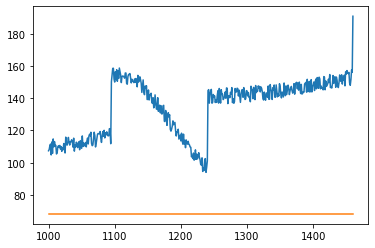

<IPython.core.display.Javascript object>

In [40]:
rnn_ss_forecast = model_forecast(rnn_ss_model, series[..., np.newaxis], window_size)[
    split_time - window_size : -1, -1, 0
]
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_ss_forecast)

## Stateful RNNs
Stateful RNNs use windows that are consecutive, and learn across the entire time series each epoch in windows, then repeat.
PROS:
    -Meaningful state vectors that aren't discarded
CONS:
    - Autocorrelation of windows means we don't descend so well
    - must be careful setting up dataset

In [41]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(1).prefetch(1)

<IPython.core.display.Javascript object>

In [42]:
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(series, window_size)

sful_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.SimpleRNN(
            100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]
        ),
        tf.keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 200.0),
    ]
)

<IPython.core.display.Javascript object>

In [47]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

<IPython.core.display.Javascript object>

In [48]:
optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
sful_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "sful-rnn-checkpoint.h5", save_best_only=True
)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
reset_states = ResetStatesCallback()

sful_model.fit(
    train_set,
    epochs=500,
    validation_data=valid_set,
    callbacks=[early_stopping, model_checkpoint, reset_states],
)
sful_model = tf.keras.models.load_model("sful-rnn-checkpoint.h5")

Epoch 1/500
33/33 [==============================] - 3s 55ms/step - loss: 8.4032 - mae: 8.8781 - val_loss: 6.3551 - val_mae: 6.8310
Epoch 2/500
33/33 [==============================] - 2s 50ms/step - loss: 8.5856 - mae: 9.0626 - val_loss: 6.0971 - val_mae: 6.5722
Epoch 3/500
33/33 [==============================] - 2s 48ms/step - loss: 8.3353 - mae: 8.8158 - val_loss: 6.0336 - val_mae: 6.5117
Epoch 4/500
33/33 [==============================] - 2s 49ms/step - loss: 8.2005 - mae: 8.6796 - val_loss: 5.9994 - val_mae: 6.4763
Epoch 5/500
33/33 [==============================] - 2s 49ms/step - loss: 8.1720 - mae: 8.6509 - val_loss: 5.9594 - val_mae: 6.4347
Epoch 6/500
33/33 [==============================] - 2s 48ms/step - loss: 8.1447 - mae: 8.6220 - val_loss: 5.9089 - val_mae: 6.3842
Epoch 7/500
33/33 [==============================] - 2s 47ms/step - loss: 8.0856 - mae: 8.5625 - val_loss: 5.8667 - val_mae: 6.3419
Epoch 8/500
33/33 [==============================] - 2s 47ms/step - loss: 8.

33/33 [==============================] - 1s 46ms/step - loss: 6.2227 - mae: 6.6877 - val_loss: 4.8896 - val_mae: 5.3668
Epoch 63/500
33/33 [==============================] - 2s 47ms/step - loss: 6.1975 - mae: 6.6626 - val_loss: 4.8778 - val_mae: 5.3549
Epoch 64/500
33/33 [==============================] - 2s 47ms/step - loss: 6.1724 - mae: 6.6375 - val_loss: 4.8661 - val_mae: 5.3431
Epoch 65/500
33/33 [==============================] - 2s 46ms/step - loss: 6.1477 - mae: 6.6128 - val_loss: 4.8544 - val_mae: 5.3313
Epoch 66/500
33/33 [==============================] - 1s 44ms/step - loss: 6.1229 - mae: 6.5882 - val_loss: 4.8428 - val_mae: 5.3196
Epoch 67/500
33/33 [==============================] - 2s 47ms/step - loss: 6.0982 - mae: 6.5638 - val_loss: 4.8311 - val_mae: 5.3077
Epoch 68/500
33/33 [==============================] - 2s 46ms/step - loss: 6.0732 - mae: 6.5392 - val_loss: 4.8196 - val_mae: 5.2960
Epoch 69/500
33/33 [==============================] - 2s 46ms/step - loss: 6.0485 

33/33 [==============================] - 1s 45ms/step - loss: 5.0706 - mae: 5.5387 - val_loss: 4.3588 - val_mae: 4.8349
Epoch 124/500
33/33 [==============================] - 2s 48ms/step - loss: 5.0580 - mae: 5.5262 - val_loss: 4.3529 - val_mae: 4.8290
Epoch 125/500
33/33 [==============================] - 1s 45ms/step - loss: 5.0455 - mae: 5.5138 - val_loss: 4.3472 - val_mae: 4.8233
Epoch 126/500
33/33 [==============================] - 1s 45ms/step - loss: 5.0332 - mae: 5.5016 - val_loss: 4.3418 - val_mae: 4.8180
Epoch 127/500
33/33 [==============================] - 1s 46ms/step - loss: 5.0211 - mae: 5.4897 - val_loss: 4.3366 - val_mae: 4.8129
Epoch 128/500
33/33 [==============================] - 1s 46ms/step - loss: 5.0094 - mae: 5.4782 - val_loss: 4.3315 - val_mae: 4.8079
Epoch 129/500
33/33 [==============================] - 1s 45ms/step - loss: 4.9979 - mae: 5.4670 - val_loss: 4.3265 - val_mae: 4.8030
Epoch 130/500
33/33 [==============================] - 1s 46ms/step - loss: 

33/33 [==============================] - 1s 45ms/step - loss: 4.5114 - mae: 4.9808 - val_loss: 4.1420 - val_mae: 4.6162
Epoch 185/500
33/33 [==============================] - 2s 46ms/step - loss: 4.5038 - mae: 4.9731 - val_loss: 4.1394 - val_mae: 4.6136
Epoch 186/500
33/33 [==============================] - 1s 45ms/step - loss: 4.4961 - mae: 4.9655 - val_loss: 4.1368 - val_mae: 4.6110
Epoch 187/500
33/33 [==============================] - 1s 45ms/step - loss: 4.4885 - mae: 4.9578 - val_loss: 4.1342 - val_mae: 4.6084
Epoch 188/500
33/33 [==============================] - 1s 46ms/step - loss: 4.4809 - mae: 4.9502 - val_loss: 4.1317 - val_mae: 4.6058
Epoch 189/500
33/33 [==============================] - 2s 48ms/step - loss: 4.4732 - mae: 4.9425 - val_loss: 4.1291 - val_mae: 4.6033
Epoch 190/500
33/33 [==============================] - 2s 47ms/step - loss: 4.4656 - mae: 4.9349 - val_loss: 4.1266 - val_mae: 4.6007
Epoch 191/500
33/33 [==============================] - 2s 50ms/step - loss: 

33/33 [==============================] - 2s 46ms/step - loss: 4.1005 - mae: 4.5649 - val_loss: 4.0299 - val_mae: 4.5028
Epoch 246/500
33/33 [==============================] - 2s 47ms/step - loss: 4.0950 - mae: 4.5594 - val_loss: 4.0292 - val_mae: 4.5021
Epoch 247/500
33/33 [==============================] - 1s 44ms/step - loss: 4.0896 - mae: 4.5540 - val_loss: 4.0285 - val_mae: 4.5014
Epoch 248/500
33/33 [==============================] - 2s 46ms/step - loss: 4.0841 - mae: 4.5485 - val_loss: 4.0278 - val_mae: 4.5007
Epoch 249/500
33/33 [==============================] - 2s 47ms/step - loss: 4.0787 - mae: 4.5431 - val_loss: 4.0272 - val_mae: 4.5001
Epoch 250/500
33/33 [==============================] - 2s 48ms/step - loss: 4.0733 - mae: 4.5377 - val_loss: 4.0265 - val_mae: 4.4995
Epoch 251/500
33/33 [==============================] - 2s 46ms/step - loss: 4.0679 - mae: 4.5323 - val_loss: 4.0258 - val_mae: 4.4988
Epoch 252/500
33/33 [==============================] - 2s 47ms/step - loss: 

33/33 [==============================] - 2s 48ms/step - loss: 3.7930 - mae: 4.2556 - val_loss: 3.9769 - val_mae: 4.4485
Epoch 307/500
33/33 [==============================] - 2s 47ms/step - loss: 3.7883 - mae: 4.2508 - val_loss: 3.9757 - val_mae: 4.4473
Epoch 308/500
33/33 [==============================] - 2s 46ms/step - loss: 3.7837 - mae: 4.2461 - val_loss: 3.9745 - val_mae: 4.4461
Epoch 309/500
33/33 [==============================] - 2s 48ms/step - loss: 3.7790 - mae: 4.2414 - val_loss: 3.9733 - val_mae: 4.4449
Epoch 310/500
33/33 [==============================] - 2s 47ms/step - loss: 3.7744 - mae: 4.2367 - val_loss: 3.9721 - val_mae: 4.4437
Epoch 311/500
33/33 [==============================] - 2s 49ms/step - loss: 3.7697 - mae: 4.2321 - val_loss: 3.9709 - val_mae: 4.4425
Epoch 312/500
33/33 [==============================] - 2s 48ms/step - loss: 3.7651 - mae: 4.2274 - val_loss: 3.9696 - val_mae: 4.4413
Epoch 313/500
33/33 [==============================] - 2s 47ms/step - loss: 

33/33 [==============================] - 2s 48ms/step - loss: 3.5472 - mae: 4.0085 - val_loss: 3.9082 - val_mae: 4.3790
Epoch 368/500
33/33 [==============================] - 2s 47ms/step - loss: 3.5437 - mae: 4.0050 - val_loss: 3.9069 - val_mae: 4.3777
Epoch 369/500
33/33 [==============================] - 2s 48ms/step - loss: 3.5402 - mae: 4.0016 - val_loss: 3.9057 - val_mae: 4.3765
Epoch 370/500
33/33 [==============================] - 2s 46ms/step - loss: 3.5367 - mae: 3.9981 - val_loss: 3.9044 - val_mae: 4.3752
Epoch 371/500
33/33 [==============================] - 2s 47ms/step - loss: 3.5332 - mae: 3.9946 - val_loss: 3.9032 - val_mae: 4.3740
Epoch 372/500
33/33 [==============================] - 2s 49ms/step - loss: 3.5297 - mae: 3.9911 - val_loss: 3.9019 - val_mae: 4.3727
Epoch 373/500
33/33 [==============================] - 2s 47ms/step - loss: 3.5262 - mae: 3.9876 - val_loss: 3.9007 - val_mae: 4.3715
Epoch 374/500
33/33 [==============================] - 1s 45ms/step - loss: 

33/33 [==============================] - 2s 47ms/step - loss: 3.3349 - mae: 3.7974 - val_loss: 3.8300 - val_mae: 4.3006
Epoch 429/500
33/33 [==============================] - 2s 48ms/step - loss: 3.3314 - mae: 3.7939 - val_loss: 3.8288 - val_mae: 4.2993
Epoch 430/500
33/33 [==============================] - 2s 48ms/step - loss: 3.3279 - mae: 3.7904 - val_loss: 3.8275 - val_mae: 4.2980
Epoch 431/500
33/33 [==============================] - 2s 46ms/step - loss: 3.3245 - mae: 3.7869 - val_loss: 3.8262 - val_mae: 4.2967
Epoch 432/500
33/33 [==============================] - 2s 47ms/step - loss: 3.3211 - mae: 3.7834 - val_loss: 3.8249 - val_mae: 4.2954
Epoch 433/500
33/33 [==============================] - 1s 45ms/step - loss: 3.3174 - mae: 3.7796 - val_loss: 3.8234 - val_mae: 4.2939
Epoch 434/500
33/33 [==============================] - 1s 45ms/step - loss: 3.3136 - mae: 3.7758 - val_loss: 3.8216 - val_mae: 4.2922
Epoch 435/500
33/33 [==============================] - 1s 45ms/step - loss: 

33/33 [==============================] - 2s 46ms/step - loss: 3.1590 - mae: 3.6196 - val_loss: 3.8362 - val_mae: 4.3086
Epoch 490/500
33/33 [==============================] - 2s 48ms/step - loss: 3.1564 - mae: 3.6169 - val_loss: 3.8368 - val_mae: 4.3093
Epoch 491/500
33/33 [==============================] - 2s 47ms/step - loss: 3.1538 - mae: 3.6143 - val_loss: 3.8374 - val_mae: 4.3099
Epoch 492/500
33/33 [==============================] - 1s 46ms/step - loss: 3.1512 - mae: 3.6117 - val_loss: 3.8380 - val_mae: 4.3105
Epoch 493/500
33/33 [==============================] - 2s 47ms/step - loss: 3.1487 - mae: 3.6090 - val_loss: 3.8387 - val_mae: 4.3112
Epoch 494/500
33/33 [==============================] - 1s 44ms/step - loss: 3.1461 - mae: 3.6064 - val_loss: 3.8393 - val_mae: 4.3118
Epoch 495/500
33/33 [==============================] - 2s 46ms/step - loss: 3.1435 - mae: 3.6038 - val_loss: 3.8400 - val_mae: 4.3125


<IPython.core.display.Javascript object>

## LSTM
Longer Short Term Memory cells can learn 100s of timesteps (neato!)
They have a long term state vector and a short term state vector, alongside forget gets and input gates and then the suual gubbins.

In [52]:
lstm_model = sful_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.LSTM(
            100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]
        ),
        tf.keras.layers.LSTM(100, return_sequences=True, stateful=True),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 200.0),
    ]
)

lstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

<IPython.core.display.Javascript object>

In [53]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
lstm_model.fit(
    train_set,
    epochs=500,
    validation_data=valid_set,
    callbacks=[early_stopping, model_checkpoint, reset_states],
)

Epoch 1/500
33/33 [==============================] - 11s 42ms/step - loss: 21.0598 - mae: 21.5577 - val_loss: 30.4692 - val_mae: 30.9650
Epoch 2/500
33/33 [==============================] - 1s 21ms/step - loss: 24.5951 - mae: 25.0910 - val_loss: 28.9128 - val_mae: 29.4069
Epoch 3/500
33/33 [==============================] - 1s 22ms/step - loss: 17.6025 - mae: 18.0935 - val_loss: 25.7326 - val_mae: 26.2270
Epoch 4/500
33/33 [==============================] - 1s 21ms/step - loss: 16.3189 - mae: 16.8099 - val_loss: 24.2295 - val_mae: 24.7222
Epoch 5/500
33/33 [==============================] - 1s 21ms/step - loss: 13.6450 - mae: 14.1371 - val_loss: 24.2287 - val_mae: 24.7226
Epoch 6/500
33/33 [==============================] - 1s 22ms/step - loss: 13.5289 - mae: 14.0263 - val_loss: 25.4772 - val_mae: 25.9703
Epoch 7/500
33/33 [==============================] - 1s 22ms/step - loss: 14.5665 - mae: 15.0637 - val_loss: 24.4331 - val_mae: 24.9253
Epoch 8/500
33/33 [============================

Epoch 62/500
33/33 [==============================] - 1s 22ms/step - loss: 4.1369 - mae: 4.6089 - val_loss: 7.6935 - val_mae: 8.1744
Epoch 63/500
33/33 [==============================] - 1s 22ms/step - loss: 4.1175 - mae: 4.5894 - val_loss: 7.6277 - val_mae: 8.1086
Epoch 64/500
33/33 [==============================] - 1s 23ms/step - loss: 4.0970 - mae: 4.5685 - val_loss: 7.5612 - val_mae: 8.0421
Epoch 65/500
33/33 [==============================] - 1s 23ms/step - loss: 4.0772 - mae: 4.5481 - val_loss: 7.5007 - val_mae: 7.9816
Epoch 66/500
33/33 [==============================] - 1s 20ms/step - loss: 4.0586 - mae: 4.5289 - val_loss: 7.4419 - val_mae: 7.9229
Epoch 67/500
33/33 [==============================] - 1s 22ms/step - loss: 4.0398 - mae: 4.5097 - val_loss: 7.3822 - val_mae: 7.8633
Epoch 68/500
33/33 [==============================] - 1s 22ms/step - loss: 4.0202 - mae: 4.4904 - val_loss: 7.3195 - val_mae: 7.8009
Epoch 69/500
33/33 [==============================] - 1s 20ms/step - 

33/33 [==============================] - 1s 21ms/step - loss: 3.3086 - mae: 3.7700 - val_loss: 5.3515 - val_mae: 5.8261
Epoch 124/500
33/33 [==============================] - 1s 22ms/step - loss: 3.3033 - mae: 3.7648 - val_loss: 5.3467 - val_mae: 5.8213
Epoch 125/500
33/33 [==============================] - 1s 20ms/step - loss: 3.2982 - mae: 3.7598 - val_loss: 5.3421 - val_mae: 5.8165
Epoch 126/500
33/33 [==============================] - 1s 21ms/step - loss: 3.2933 - mae: 3.7549 - val_loss: 5.3376 - val_mae: 5.8120
Epoch 127/500
33/33 [==============================] - 1s 22ms/step - loss: 3.2885 - mae: 3.7502 - val_loss: 5.3334 - val_mae: 5.8077
Epoch 128/500
33/33 [==============================] - 1s 21ms/step - loss: 3.2838 - mae: 3.7456 - val_loss: 5.3295 - val_mae: 5.8036
Epoch 129/500
33/33 [==============================] - 1s 22ms/step - loss: 3.2792 - mae: 3.7412 - val_loss: 5.3256 - val_mae: 5.7996
Epoch 130/500
33/33 [==============================] - 1s 21ms/step - loss: 

<IPython.core.display.Javascript object>

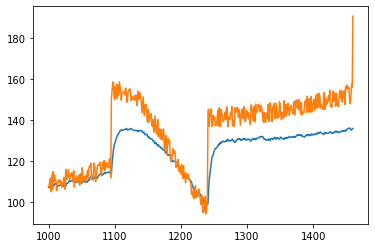

<IPython.core.display.Javascript object>

In [55]:
lstm_forecast = lstm_model.predict(series[np.newaxis, :, np.newaxis])[
    0, split_time - 1 : -1, 0
]
plt.plot(time_valid, lstm_forecast)
plt.plot(time_valid, x_valid)